# Functional metrics to evaluate network vulnerability to disasters
## in Guide to Disaster-Resilient Communication Networks, Springer, J. Rak and D. Hutchinson (Eds), 2020, in press

This notebook contains the plotting of the results generated for the chapter.

In [1]:
import pickle
import copy
import math
import functools
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt

from operator import itemgetter

from IPython.display import HTML, display

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Definitions and functions

In [2]:
num_simulations = 100
number_spectrum_units = 320
np.random.seed(42)

In [3]:
modulations = []
# modulation: string description
# capacity: Gbps
# maximum_distance: km
modulations.append({'modulation': 'BPSK', 'capacity': 12.5, 'maximum_length': 4000, 'efficiency': 1})
modulations.append({'modulation': 'QPSK', 'capacity': 25., 'maximum_length': 2000, 'efficiency': 2})
modulations.append({'modulation': '8QAM', 'capacity': 37.5, 'maximum_length': 1000, 'efficiency': 3})
modulations.append({'modulation': '16QAM', 'capacity': 50., 'maximum_length': 500, 'efficiency': 4})
modulations.append({'modulation': '32QAM', 'capacity': 62.5, 'maximum_length': 250, 'efficiency': 5})
modulations.append({'modulation': '64QAM', 'capacity': 75., 'maximum_length': 125, 'efficiency': 6})

html = '<h4>Table 1.2: Spectral efficiency and maximum reach of modulation formats.</h4><table>'
html += '<tr><th>{}</th><th>{}</th><th>{}</th></tr>'.format('Modulation', 'Spectral Efficiency (b/Hz/s)', 'Max. Length (m)')
for modulation in modulations:
    html += '<tr><td>{}</td><td>{}</td><td>{}</td></tr>'.format(modulation['modulation'], modulation['efficiency'], modulation['maximum_length'])
html += '</table>'
display(HTML(html))

Modulation,Spectral Efficiency (b/Hz/s),Max. Length (m)
BPSK,1,4000
QPSK,2,2000
8QAM,3,1000
16QAM,4,500
32QAM,5,250
64QAM,6,125


### Definitions of video

The definitions adopted in this chapter are inspired by:

https://medium.com/netflix-techblog/per-title-encode-optimization-7e99442b62a2

https://www.howtogeek.com/338983/how-much-data-does-netflix-use/

https://www.lightreading.com/video/4k-8k-video/worried-about-bandwidth-for-4k-here-comes-8k!/d/d-id/737330

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6849102

https://dl.acm.org/citation.cfm?id=2491181

In [4]:
resolutions = [] # this dictionary hosts the bit rate needed for each resolution in kbps
resolutions.append({'resolution': 'NoVideo', 'bitrate': 0})
resolutions.append({'resolution': '240p', 'bitrate': 235})
resolutions.append({'resolution': '720p', 'bitrate': 3000})
resolutions.append({'resolution': '1080p', 'bitrate': 5800})
resolutions.append({'resolution': '4k', 'bitrate': 12000})
resolutions.append({'resolution': '8k', 'bitrate': 24000})

html = '<h4>Table 1.3: List of video resolutions and their associated bit rates.</h4><table>'

html += '<tr><th>{}</th><th>{}</th></tr>'.format('Resolution', 'Bit rate (bps)')
for resolution in resolutions:
    html += '<tr><td>{}</td><td>{}</td></tr>'.format(resolution['resolution'], resolution['bitrate'])
html += '</table>'
display(HTML(html))

Resolution,Bit rate (bps)
NoVideo,0
240p,235
720p,3000
1080p,5800
4k,12000
8k,24000


In [5]:
def calculate_geographical_distance(latlong1, latlong2):
    """
    Computes the geographical distance between two nodes in the topology.
    """
    R = 6373.0
    
    lat1 = math.radians(latlong1[1])
    lon1 = math.radians(latlong1[0])
    lat2 = math.radians(latlong2[1])
    lon2 = math.radians(latlong2[0])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    length = R * c
    return length

def read_txt_file(file):
    """
    Reads a text file and converts its data into a NetworkX graph object.
    """
    graph = nx.Graph()
    nNodes = 0
    nLinks = 0
    max_population = 0
    min_population = np.finfo(1.0).max
    sum_population = 0
    id_node = 0
    id_link = 0
    with open(file, 'r') as nodes_lines:
        for idx, line in enumerate(nodes_lines):
            if idx == 0:
                nNodes = int(line)
            elif idx == 1:
                nLinks = int(line)
            elif idx > 1 and idx <= nNodes + 1: # skip title line
                info = line.replace("\n", "").split(",")
                graph.add_node(info[0], id=id_node, name=info[1], pos=(float(info[2]), float(info[3])), population=int(info[4]))
                id_node += 1
                min_population = min(min_population, int(info[4]))
                max_population = max(max_population, int(info[4]))
                sum_population += int(info[4])
#                 print(graph.nodes[info[0]])
            elif idx > 1 + nNodes and idx <= 1 + nNodes + nLinks: # skip title line
                info = line.replace("\n", "").split(",")
                n1 = graph.nodes[info[1]]
                n2 = graph.nodes[info[2]]
                dist = calculate_geographical_distance(n1['pos'], n2['pos'])
#                 print(n1['name'], n1['pos'], n2['name'], n2['pos'], '{:.2f}'.format(dist))
                graph.add_edge(info[1], info[2], id=id_link, weight=dist)
                id_link += 1
    graph.graph['min_population'] = min_population
    graph.graph['max_population'] = max_population
    graph.graph['sum_population'] = sum_population
    return graph

### Loading data

Topology data, DC placement and critical link set detection solutions come from the paper ``On the Trade-offs between User-to-Replica Distance and CDN Robustness to Link Cut Attacks`` available at [IEEEXplore](https://ieeexplore.ieee.org/abstract/document/8489838).

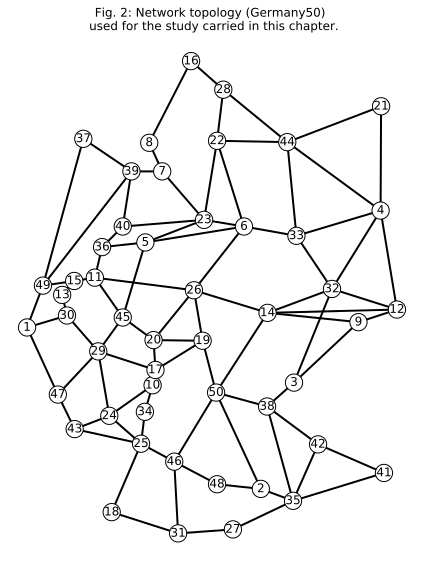

In [25]:
# loading the topology data and the DC placement data
topology = 'Germany50'
graph = read_txt_file('./topologies/Germany50-population.csv')

data_cpp = pd.read_csv('./results/sol-placement-Germany50-only-dcs.csv')
data_clsd = pd.read_csv('./results/sol-clsd-Germany50-only-dcs.csv')
budgets = [4., 5., 6.]

pos = nx.get_node_attributes(graph, 'pos')

plt.figure(figsize=(6, 8))
plt.axis('off')
plt.title('Fig. 2: Network topology (Germany50) \n used for the study carried in this chapter.')
nx.nx.draw_networkx(graph, pos, with_labels=True, width=2., node_color='white', edgecolors='black') #, labels=node_labels)
plt.tight_layout()
plt.savefig('./figures/topology.svg')
plt.show()
plt.close()

In [7]:
# describing population associated with each city
solution_cpp_4 = data_cpp[(data_cpp['budget'] == 4.)].iloc[0]
solution_cpp_5 = data_cpp[(data_cpp['budget'] == 5.)].iloc[0]
solution_cpp_6 = data_cpp[(data_cpp['budget'] == 6.)].iloc[0]

html = '<h4>Table 1: List of nodes and their associated population. Superscripts besides cities indicate which nodes were selected to host content replicas for the cases with 4, 5, and 6 replicas according to the optimal DC placement model.</h4><table>'

html += '<tr><th>{}</th><th>{}</th><th>{}</th></tr>'.format('ID', 'City', 'Population')
for idn, node in enumerate(graph.nodes()):
    superscript = ''
    if solution_cpp_4['dc_'+node] == 1:
        superscript += ' $^4$'
    if solution_cpp_5['dc_'+node] == 1:
        superscript += ' $^5$'
    if solution_cpp_6['dc_'+node] == 1:
        superscript += ' $^6$'
    html += '<tr><td>{}</td><td>{}</td><td>{}</td></tr>'.format(graph.nodes[node]['id']+1, graph.nodes[node]['name'] + superscript, graph.nodes[node]['population'])
html += '''<tr><td colspan="3">$^4$ Nodes selected to host a content replica for $\beta=4$ replicas.<br>
	$^5$ Nodes selected to host a content replica for $\beta=5$ replicas.<br>
	$^6$ Nodes selected to host a content replica for $\beta=6$ replicas.<br>
	$^*$ Numbers obtained using Google and Wikipedia.</td></tr>'''
html += '</table>'
display(HTML(html))   

ID,City,Population
1,Aachen,245885
2,Augsburg,286374
3,Bayreuth,72295
4,Berlin,3575000
5,Bielefeld,333090
6,Braunschweig,251364
7,Bremen $^5$ $^6$,557464
8,Bremerhaven,114025
9,Chemnitz,243521
10,Darmstadt,155353


In [8]:
def get_video_resolution(resolutions, bit_rate):
    for i in range(len(resolutions)-1):
        if bit_rate >= resolutions[i]['bitrate'] and bit_rate < resolutions[i+1]['bitrate']:
            return i
    if bit_rate >= resolutions[-1]['bitrate']:
        return len(resolutions) - 1
    return 0

# print(resolutions[get_video_resolution(resolutions, 1000)]) # validation of the function

In [9]:
def get_modulation_format(modulations, length):
    for i in range(len(modulations)-1):
        if length > modulations[i+1]['maximum_length'] and length <= modulations[i]['maximum_length']:
            return i
    if length <= modulations[-1]['maximum_length']:
        return len(modulations) - 1

# uncomment the following lines to test the function
# selected = get_modulation_format(modulations, 125)
# print(modulations[selected])

In [10]:
def consolidate_placement(graph, solution_cpp):
    dcs = []
    for idn, node in enumerate(graph.nodes()):
        if solution_cpp['dc_' + node] == 1:
            graph.nodes[node]['dc'] = True
            dcs.append(node)
        else:
            graph.nodes[node]['dc'] = False
    graph.graph['dcs'] = dcs
    return graph

### Functions used to compute the simulation results as described in Sec. 3.1 of the chapter ``Evaluation Setup``

In [11]:
def attr(cur_graph, original_graph):
    count = 0
    for n1 in original_graph.nodes():
        for n2 in original_graph.nodes():
            if n1 != n2 and n1 in cur_graph.nodes() and n2 in cur_graph.nodes():
                if n2 in nx.algorithms.descendants(cur_graph, n1):
                    count += 1
    return count / (original_graph.number_of_nodes() * (original_graph.number_of_nodes() - 1))

def aca(cur_graph, original_graph):
    count = 0
    for n1 in original_graph.nodes():
        for dc in original_graph.graph['dcs']:
            if n1 != dc and n1 in cur_graph.nodes() and dc in cur_graph.nodes():
                if dc in nx.algorithms.descendants(cur_graph, n1):
                    count += 1
                    break # breaks the DC loop once finds a DC
    return count / original_graph.number_of_nodes()

In [12]:
def get_anycast_betweenness_centrality(graph):
    betweenness = {}
    for n1, n2 in graph.edges():
        graph[n1][n2]['betweenness'] = 0
    for node in graph.nodes():
        if graph.nodes[node]['dc'] == False: # node is not a DC
            shortest = np.finfo(0.0).max
            for dc in graph.graph['dcs']:
                if nx.has_path(graph, node, dc):
                    length = nx.shortest_path_length(graph, node, dc, weight='weight')
                    if length < shortest:
                        shortest = length
                        path = nx.shortest_path(graph, node, dc)
            if shortest < np.finfo(0.0).max:
                for i in range(len(path) - 1):
                    graph[path[i]][path[i + 1]]['betweenness'] += 1
    return nx.get_edge_attributes(graph, 'betweenness')

In [13]:
def get_available_first_slots(graph, path, num_slots=1):
    """
    Procedure that returns the first available slot in the path selected respecting the continuity and contiguity constraints;
    -1 if no slot available
    """
    available_slots = functools.reduce(np.multiply, graph.graph['slots'][[graph[path[i]][path[i+1]]['id'] for i in range(len(path) - 1)], :])
    for index in range(len(available_slots)): # for each available slot
        if np.all(available_slots[index] == 1): # if available across all paths
            return index
    return -1

In [14]:
def get_topology_statistics(graph, temp_graph, num_simulations=5, number_spectrum_units=100):
    latencies = np.zeros((graph.number_of_nodes()))  # latency is computed in ms
    path_lenghts = np.zeros((graph.number_of_nodes()))  # path length is computed in km
    spectral_efficiency = np.zeros((graph.number_of_nodes()))  # spectral efficiency is computed as b/s/Hz
    bit_rates = np.zeros((num_simulations, graph.number_of_nodes()))  # bit rate is computed in Gbps
    arrivals = np.zeros(num_simulations) # num arrivals accommodated at each simulation
    dc_nodes = np.full((graph.number_of_nodes()), False)
    # identifying the closest DC
    total_population = 0
    source_nodes = []
    for idn, node in enumerate(temp_graph.nodes()):
        if temp_graph.nodes[node]['dc'] == True:
            dc_nodes[idn] = True
        else:  # for each non-DC node
            shortest = np.finfo(0.0).max
            for dc in temp_graph.graph['dcs']: # to each DC
                if nx.has_path(temp_graph, node, dc):
                    length = nx.shortest_path_length(temp_graph, node, dc, weight='weight')
                    if length < shortest:
                        shortest = length
                        path = nx.shortest_path(temp_graph, node, dc)
            if shortest < np.finfo(0.0).max:
                total_population += temp_graph.nodes[node]['population']
                source_nodes.append(node)  # only consider as a source if there is a path
                temp_graph.nodes[node]['shortest_path'] = path
                modulation = get_modulation_format(modulations, shortest)
                temp_graph.nodes[node]['slot_bit_rate'] = modulations[modulation]['capacity']

                # computing the latency of the shortest path im ms
                latencies[temp_graph.nodes[node]['id']] = (shortest * 1000.) / 2e8
                spectral_efficiency[temp_graph.nodes[node]['id']] = modulations[modulation]['efficiency']
                path_lenghts[temp_graph.nodes[node]['id']] = shortest

    if len(source_nodes) == 0: # if no source node is connected in this graph, halt the computations
        return False, dc_nodes, latencies, bit_rates, path_lenghts, spectral_efficiency, arrivals
    
    # defining the new node probabilities based on the graph without DCs
    probabilities = [float(temp_graph.nodes[node]['population']) / float(total_population) for node in source_nodes]
    print('\trunning simulation', end=' ')
    for simulation in range(num_simulations):
        print(simulation, end=' ')
        temp_graph.graph["slots"] = np.ones((graph.number_of_edges(), number_spectrum_units), dtype=int)

        total = np.zeros(graph.number_of_nodes())
        no_allocation = 0
        for i in range(10000000): # up to 10 M request arrivals are computed

            source = np.random.choice(source_nodes, p=probabilities) # arrival probability follows the population of each city
            total[int(source) - 1] += 1

            # provision one path from the source to its closest DC
            # note that demands are provisioned always with one slot
            # guardbands are not included for the sake of simplicity
            slot = get_available_first_slots(temp_graph, temp_graph.nodes[source]['shortest_path'])
            if slot > -1: # if there is a slot available
                arrivals[simulation] += 1
                no_allocation = 0
                for i in range(len(temp_graph.nodes[source]['shortest_path']) - 1):
                    temp_graph.graph['slots'][temp_graph[temp_graph.nodes[source]['shortest_path'][i]][temp_graph.nodes[source]['shortest_path'][i + 1]]['id'], slot] = 0
                bit_rates[simulation, graph.nodes[source]['id']] += temp_graph.nodes[source]['slot_bit_rate']
            else: # if allocation is not possible
                no_allocation += 1 # increments the counter
            if no_allocation >= 50: # if more than 50 paths could not be assigned, stop simulation
                break
    print('')
    return True, dc_nodes, latencies, bit_rates, path_lenghts, spectral_efficiency, arrivals

## Performing the computations

In [15]:
# ps_of_interest = [0] #, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# dc_nodes, latencies, bit_rates, path_lengths, spectral_efficiency = get_cdf_stats(graph, budgets, ps_of_interest, data_cpp, data_clsd, modulations)

latencies_budget = np.zeros((len(budgets), graph.number_of_nodes()))  # latency is computed in ms
bit_rates_budget = np.zeros((len(budgets), num_simulations, graph.number_of_nodes()))  # bit rate is computed in Gbps
path_lengths_budget = np.zeros((len(budgets), graph.number_of_nodes()))  # latency is computed in ms
spectral_efficiency_budget = np.zeros((len(budgets), graph.number_of_nodes()))  # latency is computed in ms
dc_nodes_budget = np.full((len(budgets), graph.number_of_nodes()), False)

for idb, budget in enumerate(budgets):
    print('budget', budget)
    solution_cpp = data_cpp[(data_cpp['budget'] == budget)].iloc[0]
    cur_graph = copy.deepcopy(graph)
    cur_graph = consolidate_placement(cur_graph, solution_cpp)
    temp_graph = copy.deepcopy(cur_graph)
    
    possible, dc_nodes_bw, latencies_bw, bit_rates_bw, path_lengths_bw, spectral_efficiency_bw, arrivals_bw = get_topology_statistics(cur_graph, temp_graph, num_simulations=num_simulations, number_spectrum_units=number_spectrum_units)
    latencies_budget[idb, :] = latencies_bw
    bit_rates_budget[idb, :] = bit_rates_bw
    path_lengths_budget[idb, :] = path_lengths_bw
    spectral_efficiency_budget[idb, :] = spectral_efficiency_bw
    dc_nodes_budget[idb, :] = dc_nodes_bw
    
latencies_budget = latencies_budget * 1000

budget 4.0
	running simulation 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
budget 5.0
	running simulation 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
budget 6.0
	running simulation 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


In [16]:
solution_cpp = data_cpp[(data_cpp['budget'] == 6.)].iloc[0]
cur_graph = copy.deepcopy(graph)
cur_graph = consolidate_placement(cur_graph, solution_cpp)

get_anycast_betweenness_centrality(cur_graph)
links_betweenness = sorted(nx.get_edge_attributes(cur_graph, 'betweenness').items(), key=itemgetter(1), reverse=True)

latency_results = {}
bit_rates_results = {}
path_length_results = {}
spectral_efficiency_results = {}
arrival_results = {}
a2tr_results = {}
aca_results = {}

for links_to_cut in range(graph.number_of_edges() - 1):
    temp_graph = copy.deepcopy(cur_graph)
    for i in range(links_to_cut):
        temp_graph.remove_edge(links_betweenness[i][0][0], links_betweenness[i][0][1])
    print('link cuts: ', links_to_cut, '/', graph.number_of_edges())
    possible, dc_nodes_bw, latencies_bw, bit_rates_bw, path_lengths_bw, spectral_efficiency_bw, arrivals_bw = get_topology_statistics(cur_graph, temp_graph, num_simulations=num_simulations, number_spectrum_units=number_spectrum_units)
    if possible:
        latency_results[links_to_cut] = latencies_bw
        bit_rates_results[links_to_cut] = bit_rates_bw
        path_length_results[links_to_cut] = path_lengths_bw
        spectral_efficiency_results[links_to_cut] = spectral_efficiency_bw
        arrival_results[links_to_cut] = arrivals_bw
        a2tr_results[links_to_cut] = attr(temp_graph, cur_graph)
        aca_results[links_to_cut] = aca(temp_graph, cur_graph)
        print('done')
    else:
        print('not possible due to lack of source nodes')
        break

link cuts:  0 / 88
	running simulation 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
done
link cuts:  1 / 88
	running simulation 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
done
link cuts:  2 / 88
	running simulation 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


In [17]:
# computing the resolutions obtained
resolution_results = {}
for links_to_cut in latency_results:
    resolution_results[links_to_cut] = {}
    for res in resolutions:
        resolution_results[links_to_cut][res['resolution']] = 0
    
for links_to_cut in latency_results:
    if len(latency_results[links_to_cut]) > 0:
        bit_rates_bw = bit_rates_results[links_to_cut]

        avg_bit_rate_node = np.mean(bit_rates_bw, axis = 0)
        for br, node in zip(avg_bit_rate_node, graph.nodes()):
            
            if cur_graph.nodes[node]['dc'] == True:
                resolution_results[links_to_cut][resolutions[-1]['resolution']] += graph.nodes[node]['population']
            else:
                res = get_video_resolution(resolutions, br)
                resolution_results[links_to_cut][resolutions[res]['resolution']] += graph.nodes[node]['population']

## Plotting

### ACA vs. ATTR

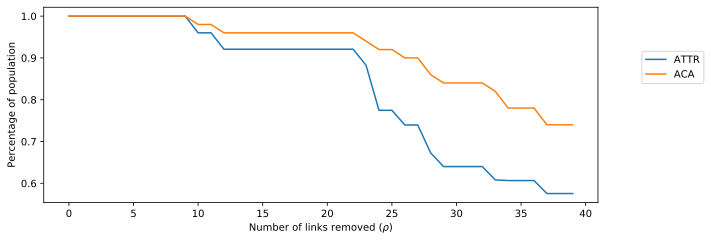

In [26]:
plt.figure(figsize=(10, 3.5))

plt.plot([a2tr_results[x] for x in a2tr_results], label='ATTR', markevery=10)
plt.plot([aca_results[x] for x in aca_results], label='ACA', markevery=10)

plt.xlabel(r'Number of links removed ($\rho$)')
plt.ylabel('Percentage of population')
plt.legend(ncol=1, bbox_to_anchor=(1.2, .8))
plt.tight_layout()
plt.savefig('./figures/a2tr-aca.svg') # uncomment to save figure
plt.show()
plt.close()

### CDF of different metrics

#### Generating Fig. 3: Cumulative Distribution Function (CDF) of the ratio of nodes for different numbers of DCs (β): (a) path length; (b) propagation latency; (c) spectral efficiency and (d) bit rate per user.

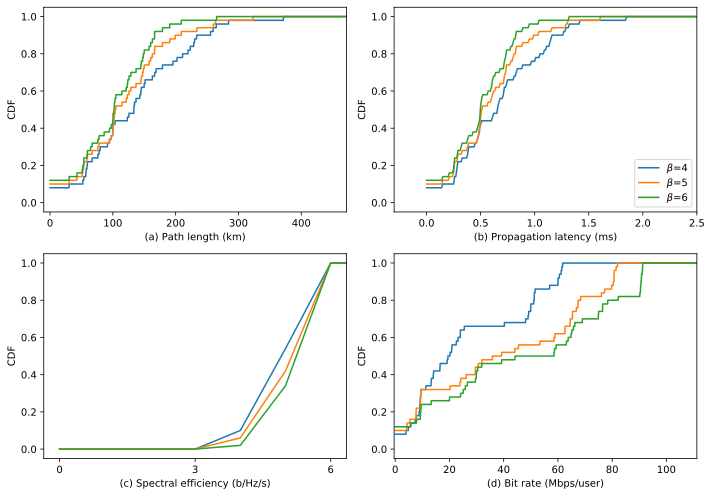

In [27]:
ylim = [-.05, 1.05]
plt.figure(figsize=(10, 7))

plt.subplot(2, 2, 1)
max_length = np.ceil(max(path_lengths_budget[:, :].reshape(path_lengths_budget.shape[0] * path_lengths_budget.shape[1])))
for id_budget, budget in enumerate(budgets):
    
    leng = np.zeros(graph.number_of_nodes())
    for idn in range(graph.number_of_nodes()):
        if dc_nodes_budget[id_budget, idn] == False and path_lengths_budget[id_budget, idn] > 0.:
            leng[idn] = path_lengths_budget[id_budget, idn]
        elif dc_nodes_budget[id_budget, idn] == True:
            leng[idn] = path_lengths_budget[id_budget, idn]
        else:
            leng[idn] = 2. * max_length

    hist, bin_edges = np.histogram(leng, bins=np.arange(0, max_length * 2., 0.01))
    plt.plot(bin_edges[:-1], np.cumsum(hist) / float(graph.number_of_nodes()), label=r'$\beta$={}'.format(int(budget)), markevery=10000)

# plt.grid(True)
plt.xlabel('(a) Path length (km)')
plt.ylabel('CDF')
#     plt.legend(loc=2)
plt.ylim(ylim)
plt.xlim([-10., max_length + 100.])
#     plt.tight_layout()
#     plt.show()
#     plt.close()

plt.subplot(2, 2, 2)

max_max_latency = .0

max_latency = np.ceil(max(latencies_budget[:, :].reshape(latencies_budget.shape[0] * latencies_budget.shape[1])))
max_max_latency = max(max_latency, max_max_latency)
    
for id_budget, budget in enumerate(budgets):
    lat = np.zeros(graph.number_of_nodes())
    for idn in range(graph.number_of_nodes()):
        if dc_nodes_budget[id_budget, idn] == False and latencies_budget[id_budget, idn] > 0.:
            lat[idn] = latencies_budget[id_budget, idn]
        elif dc_nodes_budget[id_budget, idn] == True:
            lat[idn] = latencies_budget[id_budget, idn]
        else:
            lat[idn] = 2. * max_latency
        
    hist, bin_edges = np.histogram(lat, bins=np.arange(0, max_latency * 2., 0.01))
#         print(hist, bin_edges)
    plt.plot(bin_edges[:-1], np.cumsum(hist) / float(graph.number_of_nodes()), label=r'$\beta$={}'.format(int(budget), np.mean([x for x in latencies_budget[id_budget, :] if x > .0])), markevery=100)

plt.xlabel('(b) Propagation latency (ms)')
plt.ylabel('CDF')
plt.legend(loc=4)
# plt.grid(True)
plt.xlim([-0.3, max_max_latency + .5])
plt.ylim(ylim)

#     plt.figure()
plt.subplot(2, 2, 3)
#     print(spectral_efficiency.max())
efficiencies = [x for x in range(0, int(spectral_efficiency_budget.max()) + 1)]

for id_budget, budget in enumerate(budgets):
    hist, bin_edges = np.histogram([x if dc_nodes_budget[id_budget, idn] == False else max(efficiencies) for idn, x in enumerate(spectral_efficiency_budget[id_budget, :])], bins=np.arange(0, len(efficiencies)+2, 1))
    plt.plot(bin_edges[:-1], np.cumsum(hist) / float(graph.number_of_nodes()), label=r'$\beta$={}'.format(int(budget)))
#     n, bins, patches = plt.hist([x if dc_nodes[id_budget, idn] == False else max(efficiencies) for idn, x in enumerate(spectral_efficiency[id_budget, 0, :])], normed=True, bins=len(efficiencies), cumulative=True, label=r'$B$={}'.format(int(budget)), histtype='step')
    # plt.grid(True)
    # plt.gca().set_yscale('log')
plt.xlabel('(c) Spectral efficiency (b/Hz/s)')
plt.ylabel('CDF')
# plt.legend(loc=2)
plt.xticks([0, 3, 6])
xlim = plt.xlim()
plt.xlim(xlim[0], xlim[1]-1.)
plt.ylim(ylim)
# plt.grid(True)

#     plt.figure()
plt.subplot(2, 2, 4)
max_avg_bit_rate = .0
for id_budget, budget in enumerate(budgets):
    avg_bit_rate_node = np.mean(bit_rates_budget[id_budget, :, :], axis = 0)
    avg_bit_rate_user = np.array([br / float(graph.nodes[node]['population']) for br, node in zip(avg_bit_rate_node, graph.nodes()) if dc_nodes_budget[id_budget, graph.nodes[node]['id']] == False]) * 1000.
    max_bit_rate = max(avg_bit_rate_user)
    max_avg_bit_rate = max(max_avg_bit_rate, max_bit_rate)
    avg_bit_rate_user = []
    for br, node in zip(avg_bit_rate_node, graph.nodes()):
        if dc_nodes_budget[id_budget, idn] == False:
            avg_bit_rate_user.append(br / float(graph.nodes[node]['population']) * 1000)
        else:
            avg_bit_rate_user.append(max_avg_bit_rate * 2.)
#     avg_bit_rate_user = [x if dc_nodes[id_budget, idn] == False else max_bit_rate * 2. for idn, x in enumerate(avg_bit_rate_user)]
        
    hist, bin_edges = np.histogram(avg_bit_rate_user, bins=np.arange(0, max_bit_rate * 2., 0.01))
#         print(hist, bin_edges)
#         bin_edges = [0] + bin_edges
#         hist = [0] + hist
    plt.plot(bin_edges[:-1], np.cumsum(hist) / float(graph.number_of_nodes()), label=r'$\beta$={}'.format(int(budget), np.mean([x for x in latencies_budget[id_budget, :] if x > .0])), markevery=1000)
    # plt.grid(True)
#     plt.gca().set_yscale('log')
plt.xlabel('(d) Bit rate (Mbps/user)')
plt.ylabel('CDF')
#     plt.legend(loc=2)
plt.ylim(ylim)
plt.xlim([-.4, max_avg_bit_rate + 20.])
# plt.grid(True)
#     plt.tight_layout()
#     plt.show()
#     plt.close()

plt.tight_layout()
plt.savefig('./figures/cdf-summary-budget.svg')
plt.show()
plt.close()

### Modulation vs. links removed

In [20]:
modulation_results = {}
for links_to_cut in spectral_efficiency_results:
    modulation_results[links_to_cut] = {}
    modulation_results[links_to_cut]['N/C'] = 0
    for modulation in modulations:
        modulation_results[links_to_cut][modulation['modulation']] = 0
    
for links_to_cut in modulation_results:
    
    if len(modulation_results[links_to_cut]) > 0:
#         print('link', links_to_cut)
        for eff, node in zip(spectral_efficiency_results[links_to_cut], graph.nodes()):
            
            if cur_graph.nodes[node]['dc'] == True:
                modulation_results[links_to_cut][modulations[-1]['modulation']] += 1
#                 print('\t', node, br, 'dc')
            elif eff > 0:
                
                ind = int(eff) - 1
#                 print(node, eff, modulations[ind]['modulation'])
                modulation_results[links_to_cut][modulations[ind]['modulation']] += 1
#                 print('\t', node, br, resolutions[res]['resolution'])
            else:
                modulation_results[links_to_cut]['N/C'] += 1

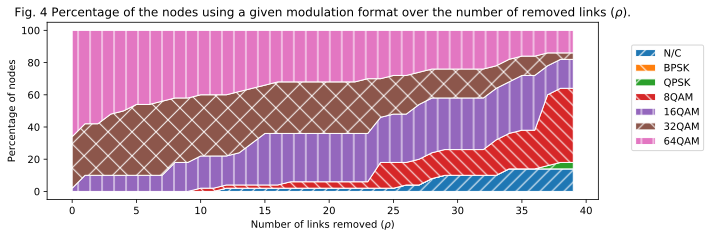

In [28]:
# print(resolution_results)
previous_value = np.zeros(len(resolution_results))

hatches = ['//', '\\', '/', '\\\\', '|', 'x', '|', '']

plt.figure(figsize=(10, 3.5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
for idr, res in enumerate(modulation_results[0]):
    value = np.array([modulation_results[links_to_cut][res] / graph.number_of_nodes() for links_to_cut in modulation_results.keys()])
    plt.fill_between(range(len(previous_value)), previous_value*100., (previous_value+value) * 100., label=res, hatch=hatches[idr], linestyle='-', linewidth=1., edgecolor='white')
    previous_value += value

plt.title(r'Fig. 4 Percentage of the nodes using a given modulation format over the number of removed links ($\rho$).')
plt.xlabel(r'Number of links removed ($\rho$)')
plt.ylabel('Percentage of nodes')
plt.legend(ncol=1, bbox_to_anchor=(1.2, .9))
plt.tight_layout()
plt.savefig('./figures/modulations-link-cut.svg')
plt.show()
plt.close()

In [22]:
html = '<h4>Consolidated results from figure 4</h4><table>'

html += '<tr><th>{}</th><th>{}</th><th>{}</th><th>{}</th></tr>'.format('Link cuts', 'ATTR', 'ACA', 'Population per resolution (%)')

for links_to_cut in resolution_results:
    html += '<tr><td>{}</td><td>{:.3f}</td><td>{:.3f}</td><td>'.format(links_to_cut, a2tr_results[links_to_cut], aca_results[links_to_cut])
    for idr, res in enumerate(modulation_results[links_to_cut]):
        value = (modulation_results[links_to_cut][res] / graph.number_of_nodes()) * 100.
        html += '<b>{}:</b> {:.2f}<br>'.format(res, value)
    html += '</td></tr>'

html += '</table>'
display(HTML(html))

Link cuts,ATTR,ACA,Population per resolution (%)
0,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 2.0032QAM: 32.0064QAM: 66.00
1,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 10.0032QAM: 32.0064QAM: 58.00
2,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 10.0032QAM: 32.0064QAM: 58.00
3,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 10.0032QAM: 38.0064QAM: 52.00
4,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 10.0032QAM: 40.0064QAM: 50.00
5,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 10.0032QAM: 44.0064QAM: 46.00
6,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 10.0032QAM: 44.0064QAM: 46.00
7,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 10.0032QAM: 46.0064QAM: 44.00
8,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 18.0032QAM: 40.0064QAM: 42.00
9,1.000,1.000,N/C: 0.00BPSK: 0.00QPSK: 0.008QAM: 0.0016QAM: 18.0032QAM: 40.0064QAM: 42.00


### Video resolution vs. links removed

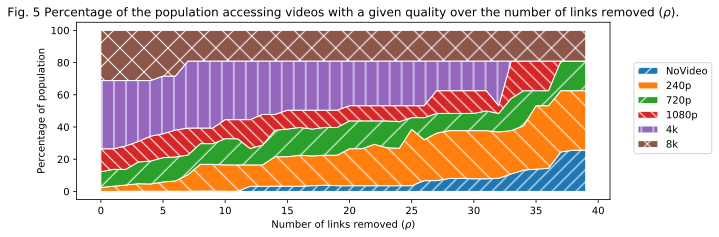

In [29]:
# print(resolution_results)
previous_value = np.zeros(len(resolution_results))

hatches = ['//', '\\', '/', '\\\\', '|', 'x']

plt.figure(figsize=(10, 3.5))
for idr, res in enumerate(resolutions):
    value = np.array([resolution_results[links_to_cut][res['resolution']] / graph.graph['sum_population'] for links_to_cut in resolution_results])
    plt.fill_between(range(len(previous_value)), previous_value*100., (previous_value+value) * 100., label=res['resolution'], hatch=hatches[idr], linestyle='-', linewidth=1., edgecolor='white')
    previous_value += value

plt.title(r'Fig. 5 Percentage of the population accessing videos with a given quality over the number of links removed ($\rho$).')
plt.xlabel(r'Number of links removed ($\rho$)')
plt.ylabel('Percentage of population')
plt.legend(ncol=1, bbox_to_anchor=(1.2, .8))
plt.tight_layout()
plt.savefig('./figures/video-quality.svg')
plt.show()
plt.close()

In [24]:
html = '<h4>Consolidated results from Fig. 5.</h4><table>'

html += '<tr><th>{}</th><th>{}</th><th>{}</th><th>{}</th></tr>'.format('Link cuts', 'ATTR', 'ACA', 'Population per resolution (%)')

for links_to_cut in resolution_results:
    html += '<tr><td>{}</td><td>{:.3f}</td><td>{:.3f}</td><td>'.format(links_to_cut, a2tr_results[links_to_cut], aca_results[links_to_cut])
    for idr, res in enumerate(resolutions):
        value = (resolution_results[links_to_cut][res['resolution']] / graph.graph['sum_population']) * 100.
        html += '<b>{}:</b> {:.3f}<br>'.format(res['resolution'], value)
    html += '</td></tr>'

html += '</table>'
display(HTML(html))   

Link cuts,ATTR,ACA,Population per resolution (%)
0,1.000,1.000,NoVideo: 0.000240p: 2.455720p: 9.7781080p: 14.2344k: 42.3518k: 31.183
1,1.000,1.000,NoVideo: 0.000240p: 3.248720p: 10.4381080p: 12.7804k: 42.3518k: 31.183
2,1.000,1.000,NoVideo: 0.114240p: 3.851720p: 9.7221080p: 14.5474k: 40.5848k: 31.183
3,1.000,1.000,NoVideo: 0.114240p: 4.686720p: 13.4881080p: 12.6834k: 37.8468k: 31.183
4,1.000,1.000,NoVideo: 0.114240p: 4.481720p: 14.2621080p: 15.4564k: 34.5048k: 31.183
5,1.000,1.000,NoVideo: 0.114240p: 5.755720p: 15.0921080p: 14.8254k: 35.8298k: 28.385
6,1.000,1.000,NoVideo: 0.114240p: 6.393720p: 14.8961080p: 16.7174k: 33.4958k: 28.385
7,1.000,1.000,NoVideo: 0.114240p: 10.268720p: 12.2151080p: 16.7354k: 41.5948k: 19.074
8,1.000,1.000,NoVideo: 0.243240p: 16.571720p: 12.8361080p: 9.6824k: 41.5948k: 19.074
9,1.000,1.000,NoVideo: 0.243240p: 16.571720p: 12.8361080p: 9.6824k: 41.5948k: 19.074
